Solution for Assignment 6 of the course “Introduction to Machine Learning” at the University of Leoben.
Author: Fotios Lygerakis
Semester: SS 2022/2023

Implement the Gaussian Processes algorithm as a class in Python. The class should be able to perform the following tasks:
1. Fit the model to a given training data set (X, y) with X ∈ Rn×d and y ∈ Rn.
2. Predict the output for a given test data set X∗ ∈ Rm×d.
3. Compute the log marginal likelihood of the training data set.
4. Compute the gradients of the log marginal likelihood with respect to the hyperparameters.
5. Compute the predictive mean and variance for a given test data set X∗ ∈ Rm×d.
6. Compute the gradients of the predictive mean and variance with respect to the hyperparameters.
7. Use the gradients of the log marginal likelihood and the gradients of the predictive mean and variance to optimize the hyperparameters of the kernel function.

Implement the following kernel functions:
1. linear kernel: k(x, x′) = xT x′
2. polynomial kernel: k(x, x′) = (xT x′ + 1)d
3. Periodic kernel: k(x, x′) = exp(−2sin2(π||x − x′||/p)/σ2)
4. Gaussian kernel: k(x, x′) = exp(−||x − x′||2/2σ2)

Test your implementation on 1D, 2D and 3D data sets. Compare the results with the results of the scikit-learn implementation of Gaussian Processes.

Import the necessary libraries

In [370]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist


Datasets

In [371]:
step_size = 0.5
#1D data set
X_1D = np.arange(-5, 5, step_size).reshape(-1, 1)
y_1D = np.sin(X_1D) + np.random.normal(0, 0.1, size=(len(X_1D), 1))
X_1D_star = np.arange(-5, 5, step_size).reshape(-1, 1)

#2D data set
X_2D_1 = np.arange(-5, 5, step_size).reshape(-1, 1)
X_2D_2 = np.arange(-5, 5, step_size).reshape(-1, 1)
X_2D = np.hstack((X_2D_1, X_2D_2))
y_2D = np.sin(X_2D_1) + np.exp(X_2D_2) + np.random.normal(0, 0.1, size=(len(X_2D), 1))
X_2D_star_1 = np.arange(-5, 5, step_size).reshape(-1, 1)
X_2D_star_2 = np.arange(-5, 5, step_size).reshape(-1, 1)
X_2D_star = np.hstack((X_2D_star_1, X_2D_star_2))

#3D data set
X_3D_1 = np.arange(-5, 5, step_size).reshape(-1, 1)
X_3D_2 = np.arange(-5, 5, step_size).reshape(-1, 1)
X_3D_3 = np.arange(-5, 5, step_size).reshape(-1, 1)
X_3D = np.hstack((X_3D_1, X_3D_2, X_3D_3))
y_3D = (
    np.sin(X_3D_1)
    + np.cos(X_3D_2)
    + X_3D_3 ** 2
    + np.random.normal(0, 0.1, size=(len(X_3D), 1))
)
X_3D_star_1 = np.arange(-5, 5, step_size).reshape(-1, 1)
X_3D_star_2 = np.arange(-5, 5, step_size).reshape(-1, 1)
X_3D_star_3 = np.arange(-5, 5, step_size).reshape(-1, 1)
X_3D_star = np.hstack((X_3D_star_1, X_3D_star_2, X_3D_star_3))


Implement the Gaussian Processes algorithm as a class in Python

In [372]:
class GaussianProcess:
    def __init__(self, kernel, sigma_n=1e-8):
        self.kernel = kernel
        self.sigma_n = sigma_n
        self.X = None
        self.y = None
        self.K = None
        self.K_inv = None
        self.alpha = None

    def fit(self, X, y):
        # Compute the kernel matrix. Add a small value to the diagonal for numerical stability.
        # Compute the inverse of the kernel matrix.
        # Compute the coefficients alpha.
        self.X = X
        self.y = y
        self.K = self.kernel(X, X) + self.sigma_n**2 * np.eye(len(X))
        self.K_inv = np.linalg.pinv(self.K)  # Compute the pseudo-inverse of the kernel matrix.
        self.alpha = np.dot(self.K_inv, y)

    def predict(self, X_star):
        # Compute the kernel matrix between the training data and the test data.
        # Compute the predictive mean.
        # Compute the predictive variance.
        K_star = self.kernel(self.X, X_star)
        y_star = np.dot(K_star, self.alpha)
        K_star_star = self.kernel(X_star, X_star)
        var = K_star_star - np.dot(K_star.T, np.dot(self.K_inv, K_star))
        return y_star, var

    def log_marginal_likelihood(self):
        # Compute the log marginal likelihood.
        lml = -0.5 * np.dot(self.y.T, self.alpha) - 0.5 * np.log(np.linalg.det(self.K)) - 0.5 * len(self.X) * np.log(2*np.pi)
        return lml

    def plot(self, X_star, y_star, var):
        plt.figure(figsize=(10, 10))
        plt.plot(self.X, self.y, "r.", markersize=10, label="Observations")
        plt.plot(X_star, y_star, "b-", label="Prediction")
        plt.fill_between(
            X_star[:, 0],
            y_star[:, 0] - 1.96 * np.sqrt(np.diag(var)),
            y_star[:, 0] + 1.96 * np.sqrt(np.diag(var)),
            alpha=0.2,
            color="k",
            label="95% confidence interval",
        )
        plt.xlabel("$x$")
        plt.ylabel("$y$")
        plt.title(
            f"{self.kernel.__class__.__name__} \n Log-Marginal-Likelihood: {self.log_marginal_likelihood()[0][0]:.3e}"
        )
        plt.legend(loc="upper left")
        plt.show()

In [373]:
#Implement the linear kernel function
class LinearKernel:
    def __init__(self, theta=1.0):
        self.theta = theta

    def __call__(self, X1, X2):
        return np.dot(X1, X2.T)

    def set_params(self, params):
        self.theta = params


In [374]:
#Implement the polynomial kernel function
class PolynomialKernel:
    def __init__(self, theta=1.0, d=3):
        self.theta = theta
        self.d = d

    def __call__(self, X1, X2):
        return (np.dot(X1, X2.T) + 1) ** self.d

    def set_params(self, params):
        self.theta, self.d = params

In [375]:
#Implement the periodic kernel function
class PeriodicKernel:
    def __init__(self, theta=1.0):
        self.theta = theta

    def __call__(self, X1, X2):
        distance = np.linalg.norm(X1 - X2)
        exponent = -2 * np.sin(np.pi * distance / self.theta) ** 2
        kernel_value = np.exp(exponent)
        return kernel_value

    def set_params(self, params):
        self.theta = params

In [376]:
#Implement the radial basis function kernel function
class RBFKernel:
    def __init__(self, theta=1.0):
        self.theta = theta

    def __call__(self, X1, X2):
        pairwise_dists = cdist(X1, X2, metric='euclidean')
        return np.exp(-0.5 * self.theta * pairwise_dists**2)


    def set_params(self, params):
        self.theta = params


### Test your implementation. Compare the results with the results of the scikit-learn implementation of Gaussian Processes.

Initialize the kernels

In [377]:
#Linear kernel
kernel_linear = LinearKernel()
#Polynomial kernel
kernel_poly = PolynomialKernel()
#Periodic kernel
kernel_periodic = PeriodicKernel()
#Radial basis function kernel
kernel_rbf = RBFKernel()

### Initialize the Gaussian Process with the kernels and fit the data

In [378]:
gp_linear = GaussianProcess(kernel_linear)
gp_poly = GaussianProcess(kernel_poly)
gp_periodic = GaussianProcess(kernel_periodic)
gp_rbf = GaussianProcess(kernel_rbf)

### Fit the 1D data

In [379]:
gp_linear.fit(X_1D, y_1D)
gp_poly.fit(X_1D, y_1D)
gp_periodic.fit(X_1D, y_1D)
gp_rbf.fit(X_1D, y_1D)

### Predict the values of the test data

In [380]:
y_star_linear, var_linear = gp_linear.predict(X_1D_star)
y_star_poly, var_poly = gp_poly.predict(X_1D_star)
y_star_periodic, var_periodic = gp_periodic.predict(X_1D_star)
y_star_rbf, var_rbf = gp_rbf.predict(X_1D_star)

### Plot the results

/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:42: RuntimeWarning: invalid value encountered in sqrt
  y_star[:, 0] - 1.96 * np.sqrt(np.diag(var)),
/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:43: RuntimeWarning: invalid value encountered in sqrt
  y_star[:, 0] + 1.96 * np.sqrt(np.diag(var)),
/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:33: RuntimeWarning: divide by zero encountered in log
  lml = -0.5 * np.dot(self.y.T, self.alpha) - 0.5 * np.log(np.linalg.det(self.K)) - 0.5 * len(self.X) * np.log(2*np.pi)


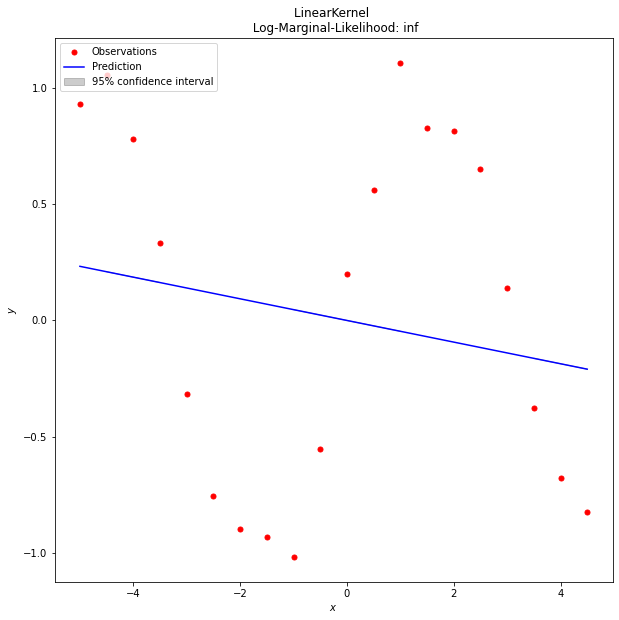

/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:42: RuntimeWarning: invalid value encountered in sqrt
  y_star[:, 0] - 1.96 * np.sqrt(np.diag(var)),
/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:43: RuntimeWarning: invalid value encountered in sqrt
  y_star[:, 0] + 1.96 * np.sqrt(np.diag(var)),
/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:33: RuntimeWarning: invalid value encountered in log
  lml = -0.5 * np.dot(self.y.T, self.alpha) - 0.5 * np.log(np.linalg.det(self.K)) - 0.5 * len(self.X) * np.log(2*np.pi)


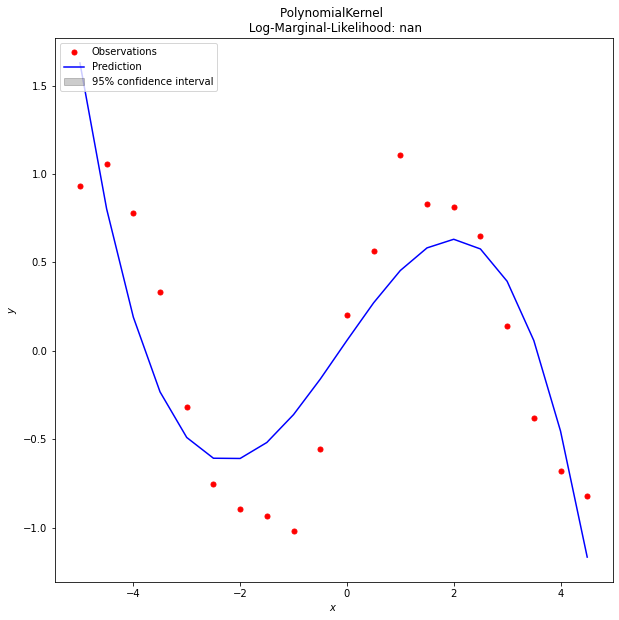

/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:33: RuntimeWarning: divide by zero encountered in log
  lml = -0.5 * np.dot(self.y.T, self.alpha) - 0.5 * np.log(np.linalg.det(self.K)) - 0.5 * len(self.X) * np.log(2*np.pi)


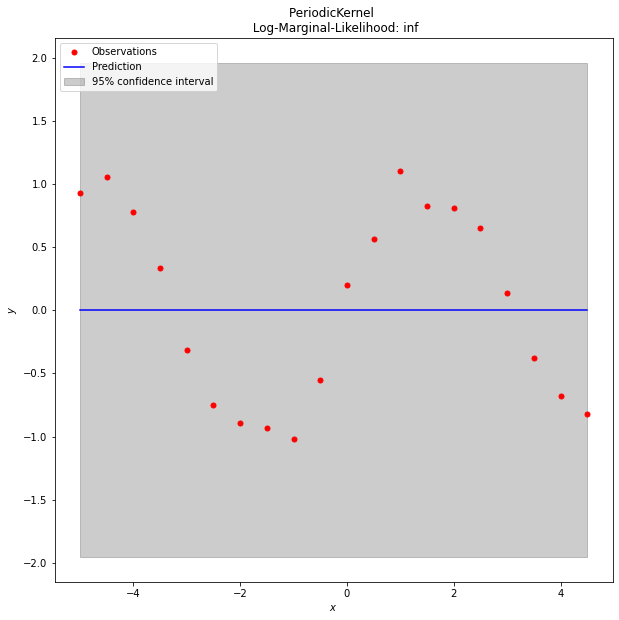

/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:42: RuntimeWarning: invalid value encountered in sqrt
  y_star[:, 0] - 1.96 * np.sqrt(np.diag(var)),
/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:43: RuntimeWarning: invalid value encountered in sqrt
  y_star[:, 0] + 1.96 * np.sqrt(np.diag(var)),


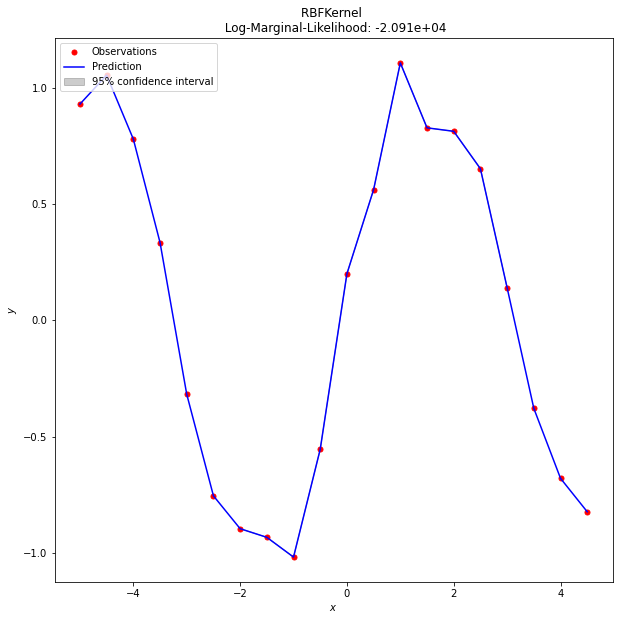

In [381]:
gp_linear.plot(X_1D_star, y_star_linear, var_linear)
gp_poly.plot(X_1D_star, y_star_poly, var_poly)
gp_periodic.plot(X_1D_star, y_star_periodic, var_periodic)
gp_rbf.plot(X_1D_star, y_star_rbf, var_rbf)

### Fit the 2D data

In [382]:
gp_linear.fit(X_2D, y_2D)
gp_poly.fit(X_2D, y_2D)
gp_periodic.fit(X_2D, y_2D)
gp_rbf.fit(X_2D, y_2D)

### Predict the values of the test data

In [383]:
y_star_linear, var_linear = gp_linear.predict(X_2D_star)
y_star_poly, var_poly = gp_poly.predict(X_2D_star)
y_star_periodic, var_periodic = gp_periodic.predict(X_2D_star)
y_star_rbf, var_rbf = gp_rbf.predict(X_2D_star)

### Plot the results

/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:42: RuntimeWarning: invalid value encountered in sqrt
  y_star[:, 0] - 1.96 * np.sqrt(np.diag(var)),
/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:43: RuntimeWarning: invalid value encountered in sqrt
  y_star[:, 0] + 1.96 * np.sqrt(np.diag(var)),
/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:33: RuntimeWarning: divide by zero encountered in log
  lml = -0.5 * np.dot(self.y.T, self.alpha) - 0.5 * np.log(np.linalg.det(self.K)) - 0.5 * len(self.X) * np.log(2*np.pi)


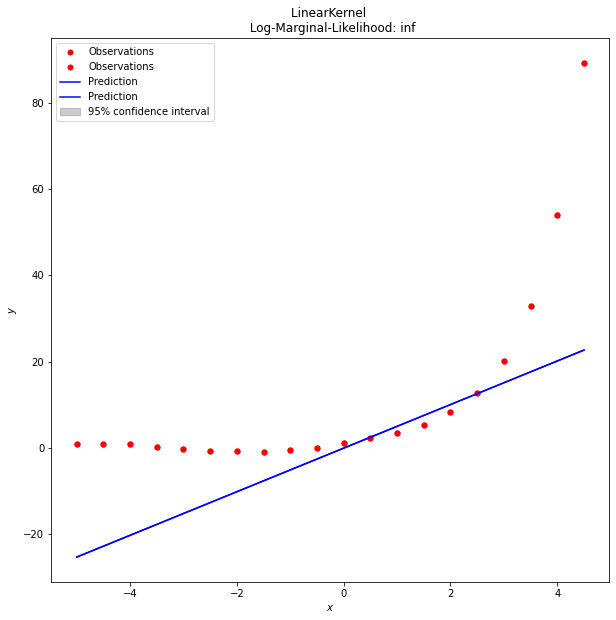

/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:42: RuntimeWarning: invalid value encountered in sqrt
  y_star[:, 0] - 1.96 * np.sqrt(np.diag(var)),
/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:43: RuntimeWarning: invalid value encountered in sqrt
  y_star[:, 0] + 1.96 * np.sqrt(np.diag(var)),


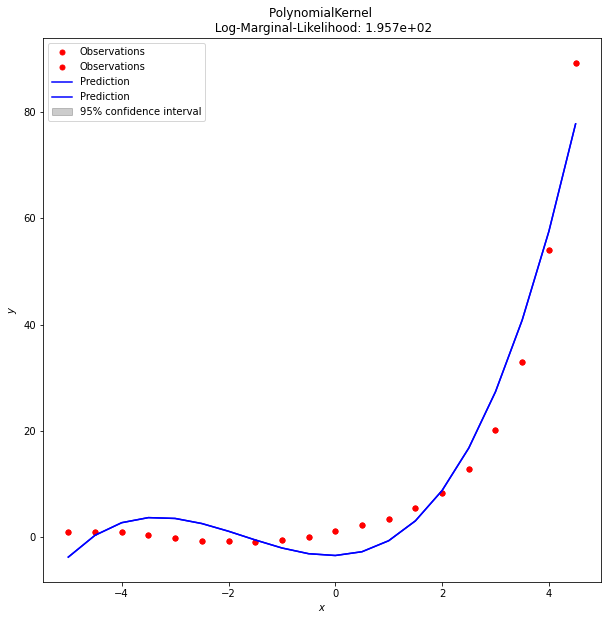

/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:33: RuntimeWarning: divide by zero encountered in log
  lml = -0.5 * np.dot(self.y.T, self.alpha) - 0.5 * np.log(np.linalg.det(self.K)) - 0.5 * len(self.X) * np.log(2*np.pi)


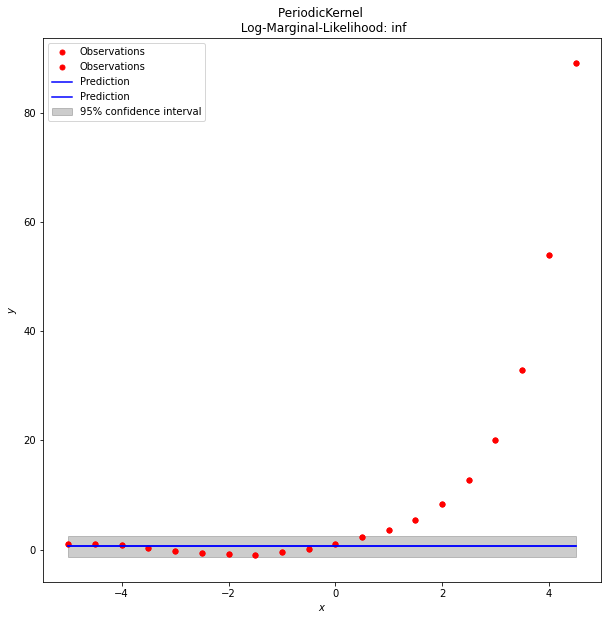

/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:42: RuntimeWarning: invalid value encountered in sqrt
  y_star[:, 0] - 1.96 * np.sqrt(np.diag(var)),
/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:43: RuntimeWarning: invalid value encountered in sqrt
  y_star[:, 0] + 1.96 * np.sqrt(np.diag(var)),


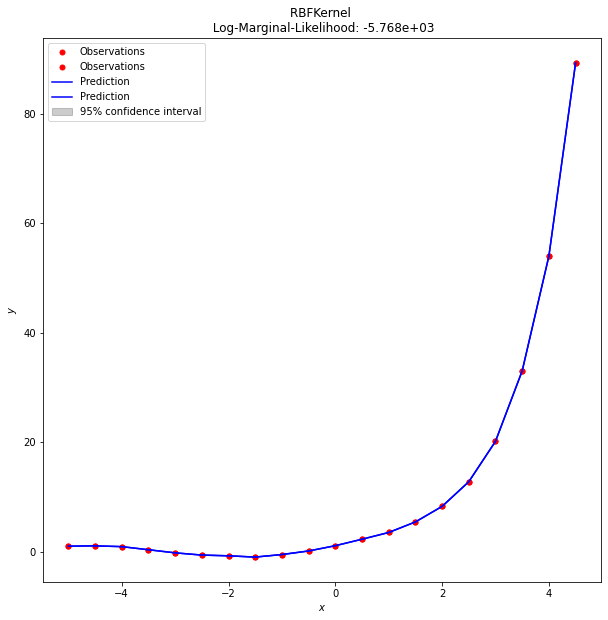

In [384]:
gp_linear.plot(X_2D_star, y_star_linear, var_linear)
gp_poly.plot(X_2D_star, y_star_poly, var_poly)
gp_periodic.plot(X_2D_star, y_star_periodic, var_periodic)
gp_rbf.plot(X_2D_star, y_star_rbf, var_rbf)

### Fit the 3D data

In [385]:
gp_linear.fit(X_3D, y_3D)
gp_poly.fit(X_3D, y_3D)
gp_periodic.fit(X_3D, y_3D)
gp_rbf.fit(X_3D, y_3D)

### Predict the values of the test data

In [386]:
y_star_linear, var_linear = gp_linear.predict(X_3D_star)
y_star_poly, var_poly = gp_poly.predict(X_3D_star)
y_star_periodic, var_periodic = gp_periodic.predict(X_3D_star)
y_star_rbf, var_rbf = gp_rbf.predict(X_3D_star)

### Plot the results

/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:42: RuntimeWarning: invalid value encountered in sqrt
  y_star[:, 0] - 1.96 * np.sqrt(np.diag(var)),
/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:43: RuntimeWarning: invalid value encountered in sqrt
  y_star[:, 0] + 1.96 * np.sqrt(np.diag(var)),
/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:33: RuntimeWarning: divide by zero encountered in log
  lml = -0.5 * np.dot(self.y.T, self.alpha) - 0.5 * np.log(np.linalg.det(self.K)) - 0.5 * len(self.X) * np.log(2*np.pi)


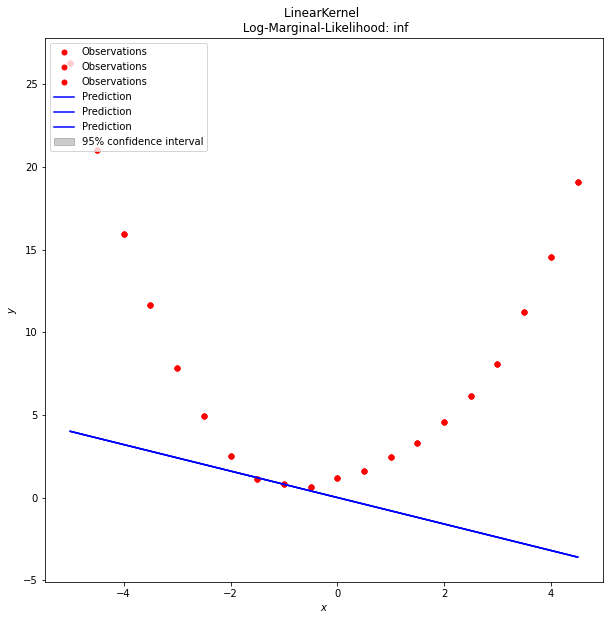

/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:42: RuntimeWarning: invalid value encountered in sqrt
  y_star[:, 0] - 1.96 * np.sqrt(np.diag(var)),
/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:43: RuntimeWarning: invalid value encountered in sqrt
  y_star[:, 0] + 1.96 * np.sqrt(np.diag(var)),
/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:33: RuntimeWarning: invalid value encountered in log
  lml = -0.5 * np.dot(self.y.T, self.alpha) - 0.5 * np.log(np.linalg.det(self.K)) - 0.5 * len(self.X) * np.log(2*np.pi)


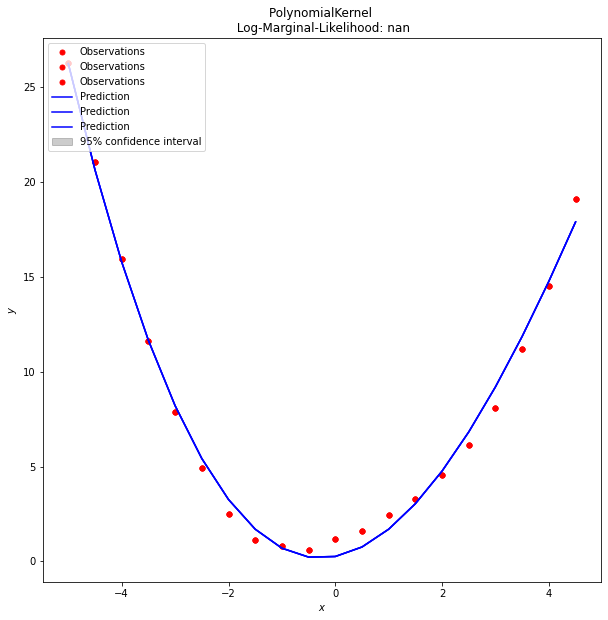

/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:33: RuntimeWarning: divide by zero encountered in log
  lml = -0.5 * np.dot(self.y.T, self.alpha) - 0.5 * np.log(np.linalg.det(self.K)) - 0.5 * len(self.X) * np.log(2*np.pi)


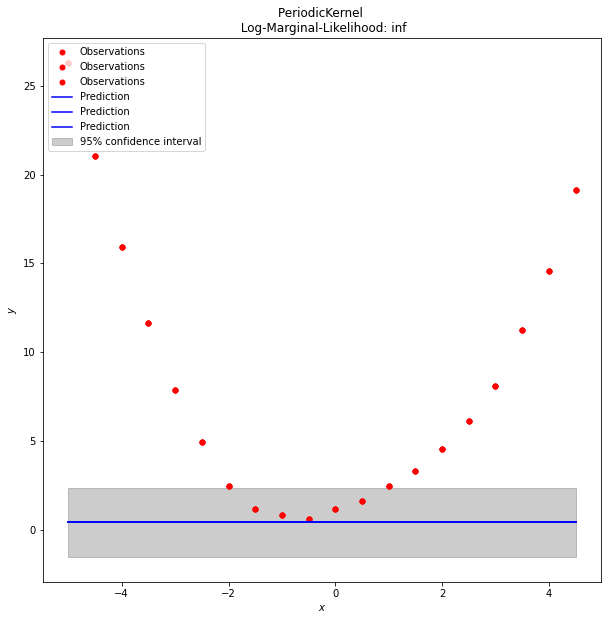

/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:42: RuntimeWarning: invalid value encountered in sqrt
  y_star[:, 0] - 1.96 * np.sqrt(np.diag(var)),
/var/folders/1q/vgd6s6h953735drfl5vfrzy80000gn/T/ipykernel_8593/3635396924.py:43: RuntimeWarning: invalid value encountered in sqrt
  y_star[:, 0] + 1.96 * np.sqrt(np.diag(var)),


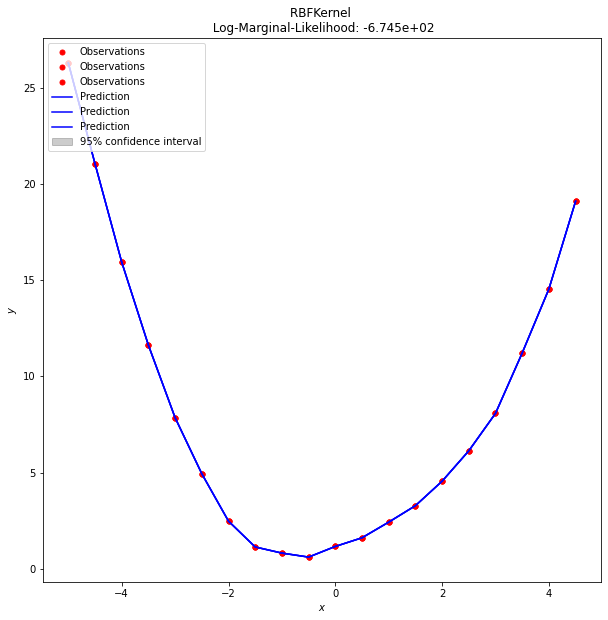

In [387]:
gp_linear.plot(X_3D_star, y_star_linear, var_linear)
gp_poly.plot(X_3D_star, y_star_poly, var_poly)
gp_periodic.plot(X_3D_star, y_star_periodic, var_periodic)
gp_rbf.plot(X_3D_star, y_star_rbf, var_rbf)

Compare the results with the results of the scikit-learn implementation of Gaussian Processes

In [388]:
#import the scikit-learn implementation of Gaussian Processes
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [389]:
# Fit the sklearn model
sklearn_gp = GaussianProcessRegressor(kernel=RBF())
sklearn_gp.fit(X_1D, y_1D)

# Fit the custom model
gp_rbf.fit(X_1D, y_1D)

/Users/gimchaehyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


### Predict the values of the test data

In [390]:
# Predict the mean and variance of the test data using the scikit-learn implementation
y_star, var = sklearn_gp.predict(X_1D_star, return_std=True)
# Predict the mean and variance of the test data using the custom implementation
y_star_rbf, var_rbf = gp_rbf.predict(X_1D_star)

Plot the results comparing with the results of the scikit-learn with the ccustom implementation of Gaussian Processes using the RBF kernel

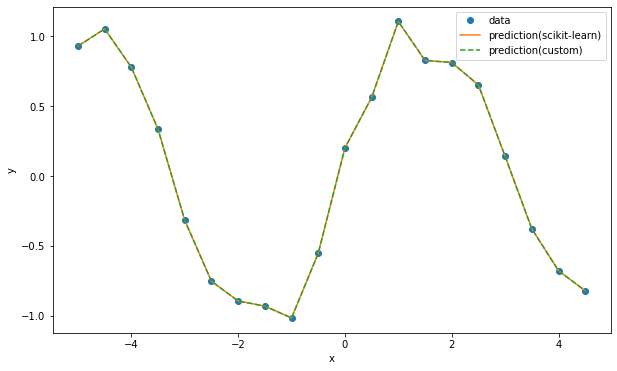

In [391]:
plt.figure(figsize=(10, 6))
plt.plot(X_1D, y_1D, "o", label="data")

plt.plot(X_1D_star, y_star, "-", label="prediction(scikit-learn)")
plt.plot(X_1D_star, y_star_rbf, "--", label="prediction(custom)")

plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="best")

# Bonus: Use the Gaussian Process to fit any dataset of your choice

/Users/gimchaehyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the Californi

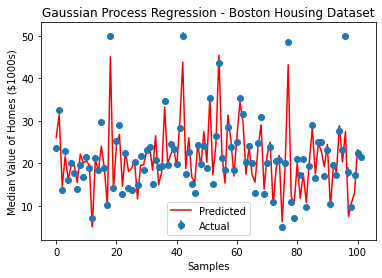

In [392]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt

# Load the Boston Housing dataset
boston = load_boston()
X, y = boston.data, boston.target

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create a Gaussian Process regressor with an RBF kernel
kernel = RBF(length_scale=1.0)
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1)

# Fit the model to the training data
gp.fit(X_train, y_train)

# Predict on the test data
y_pred, std = gp.predict(X_test, return_std=True)

# Plot the predicted values with error bars
plt.errorbar(range(len(y_test)), y_test, yerr=1.96 * std, fmt='o', label='Actual')
plt.plot(range(len(y_test)), y_pred, 'r-', label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Median Value of Homes ($1000s)')
plt.title('Gaussian Process Regression - Boston Housing Dataset')
plt.legend()
plt.show()
